What we want to see is if we can use the ingredient and keyword list to predict the rating. Transform this previous regression problem into a binary classifier and clean up the feature set. You can choose whether or not to include nutritional information, but try to cut your feature set down to the 30 most valuable features.

In [18]:
import numpy as np
import pandas as pd
import scipy
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.svm import SVC
from sklearn.model_selection import train_test_split
import warnings
warnings.filterwarnings('ignore')
%matplotlib inline

In [2]:
data = pd.read_csv('https://tf-assets-prod.s3.amazonaws.com/tf-curric/data-science/epi_r.csv')

In [13]:
data.head(100)

,title,rating,calories,protein,fat,sodium,#cakeweek,#wasteless,22-minute meals,3-ingredient recipes,...,yellow squash,yogurt,yonkers,yuca,zucchini,cookbooks,leftovers,snack,snack week,turkey
0,"Lentil, Apple, and Turkey Wrap",0,426.0,30.0,7.0,559.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
1,Boudin Blanc Terrine with Red Onion Confit,1,403.0,18.0,23.0,1439.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,Potato and Fennel Soup Hodge,1,165.0,6.0,7.0,165.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,Mahi-Mahi in Tomato Olive Sauce,1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,Spinach Noodle Casserole,0,547.0,20.0,32.0,452.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
5,The Best Blts,1,948.0,19.0,79.0,1042.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
6,Ham and Spring Vegetable Salad with Shallot Vi...,1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
7,Spicy-Sweet Kumquats,1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
8,Korean Marinated Beef,1,170.0,7.0,10.0,1272.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
9,Ham Persillade with Mustard Potato Salad and M...,1,602.0,23.0,41.0,1696.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


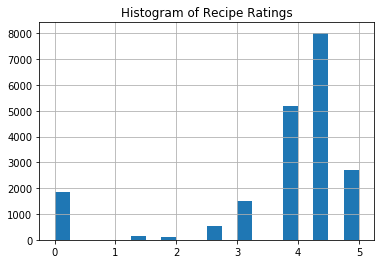

In [3]:
data.rating.hist(bins=20)
plt.title('Histogram of Recipe Ratings')
plt.show()

In [4]:
missing_data = data.isnull().sum()[data.isnull().sum()>0]
print('We have {} columns'.format(len(data.columns)))
missing_data

We have 680 columns


calories    4117
protein     4162
fat         4183
sodium      4119
dtype: int64

In [5]:
missing_data = missing_data.index.to_list()
rplc_dct = {np.nan:0}
for i in missing_data:
    data[i] = data[i].replace(rplc_dct)

In [6]:
def binarize(x):
    if x <= data['rating'].mean():
        return 0
    return 1

data['rating'] = data['rating'].apply(binarize)

Let's play a bit with the data to see what we can know about it:

In [7]:
data.head()
[i for i in data.columns.to_list() if i.startswith('#')]

['#cakeweek', '#wasteless']

We'll add the most positively & negatively correlated columns together in a list:

In [8]:
rating_corr = data.corr().abs()['rating'].sort_values(ascending=False)
rating_corr = rating_corr[:30].index.to_list()

In [9]:
rating_corr

['rating',
 'drink',
 'alcoholic',
 'house & garden',
 'gin',
 'bon appétit',
 'cocktail party',
 'cocktail',
 'spirit',
 'bitters',
 'harpercollins',
 'rum',
 'liqueur',
 'sauté',
 'peanut free',
 'bake',
 'condiment',
 'roast',
 'soy free',
 'non-alcoholic',
 'fall',
 'tree nut free',
 'winter',
 'low carb',
 'créme de cacao',
 'vegan',
 'weelicious',
 'tomato',
 'dinner',
 'lime juice']

We can see that the most correlated columns are descriptive tags for the recipes and not ingredients. Bon appétit is french for *In good appetite* and seems to be the name of some sort of special list. There are also columns that represent tags for sensetive groups and certain events.

# Feature Engineering

# SVC Model

In [23]:
svc = SVC()
X = data[['drink',
 'alcoholic',
 'house & garden',
 'gin',
 'bon appétit',
 'cocktail party',
 'cocktail',
 'spirit',
 'bitters',
 'harpercollins',
 'rum',
 'liqueur',
 'sauté',
 'peanut free',
 'bake',
 'condiment',
 'roast',
 'soy free',
 'non-alcoholic',
 'fall',
 'tree nut free',
 'winter',
 'low carb',
 'créme de cacao',
 'vegan',
 'weelicious',
 'tomato',
 'dinner',
 'lime juice']].sample(frac=0.3, replace=True, random_state=1)
Y = data.rating.sample(frac=0.3, replace=True, random_state=1)
svc.fit(X,Y)

SVC(C=1.0, cache_size=200, class_weight=None, coef0=0.0,
    decision_function_shape='ovr', degree=3, gamma='auto_deprecated',
    kernel='rbf', max_iter=-1, probability=False, random_state=None,
    shrinking=True, tol=0.001, verbose=False)

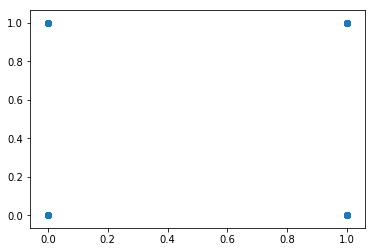

In [25]:
plt.scatter(Y, svc.predict(X))

In [26]:
X_train, X_test, y_train, y_test = train_test_split(X,Y)

In [27]:
svc.score(X_train,y_train)

0.8045212765957447